# 🦜🕸️ LangGraph Fundamentals: Building Stateful AI Agents - Interactive Demo

**Welcome to the LangGraph demonstration!**

In the previous notebook, we built **Chains** (Linear workflows: A → B → C).  
Now, we're building **Graphs** - powerful, cyclical workflows that enable sophisticated agent behaviors.

Real-world AI tasks aren't always linear. Sometimes you need to:
- Loop back and retry a step based on results
- Make decisions that change the workflow dynamically
- Pause execution to ask humans for input or approval
- Maintain state across multiple reasoning and action cycles

This demo shows you how to build production-ready AI agents that can handle complex, multi-step tasks autonomously.

## 📚 What This Demo Covers

### **1. Tools (Agent Capabilities)**
The "Skills" we give our agent - like checking leave balances, processing requests, or calling external APIs.

### **2. State (Shared Memory)**
The "Shared Notebook" that tracks the conversation history, user information, and context across all steps.

### **3. Nodes (Processing Steps)**
The specific operations in your workflow - thinking (LLM reasoning) vs. acting (tool execution).

### **4. Edges (Workflow Logic)**
The connections between nodes that create loops, branches, and conditional routing based on agent decisions.

### **5. Human-in-the-Loop**
Pausing agent execution to request clarification, approval, or additional information from users.

### **6. Persistence (State Management)**
Saving the "conversation state" so agents can resume exactly where they left off, even across sessions.

---

**This demo demonstrates:**
- How agents reason through multi-step problems
- When and how agents decide to use tools
- Managing conversation context and state
- Building interactive agents that collaborate with humans
- Creating resumable, production-ready agent workflows

In [3]:
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage, AIMessage
from dotenv import load_dotenv
import os

In [4]:
os.environ["LANGSMITH_TRACING"] = "true" # false for no tracing  
os.environ["LANGSMITH_PROJECT"] = "Langraph-Workshop-Dec20"
load_dotenv()

True

## 1) Defining Tools (Agent Skills)

Imagine hiring an assistant. Before they start, you give them a specific set of tools: a **Calculator** (to check balances) and a **Calendar Stamp** (to book time off).
The assistant doesn't use them randomly; they look at the tool's manual (the docstring) to know *when* and *how* to use them.

### Code Context
In the code below:
* `@tool`: Converts a standard Python function into a tool the LLM can understand.
* **Docstrings (`'''...'''`)**: These are crucial! The LLM reads these to understand that `get_time_off_balance` requires a `user_id`.
* We define two tools: one to **Read** data (get balance) and one to **Write** data (process leave).

📚 **[Docs: LangChain Tools](https://docs.langchain.com/oss/python/langchain/tools)**

In [5]:
from datetime import datetime
from langchain.tools import tool

In [ ]:
@tool
def get_time_off_balance(user_id: str) -> int:
    '''
    Get the time off balance for a user. 

    Args :
        user_id: A unique string representing the user id

    Returns:
        An integer value representing the time-off balance
    '''
    return 10

@tool
def process_time_off(user_id: str, start_date: str, end_date: str) -> dict:
    '''
    Process time-off request for a user

    Args :
        user_id: A unique string representing the user id
        start_date: A date string in YYYY-MM-DD format for the start date of the time-off request
        end_date: A date string in YYYY-MM-DD format for the end date of the time-off request

    Returns:
        A dictionary with the following keys:
        - status: A string value representing the status of the time-off request
        - message: A string value representing the message of the time-off request
    '''
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    days_requested = end_date - start_date
    time_off_balance = get_time_off_balance.invoke({"user_id": user_id})

    result = {}

    if days_requested.days + 1 > time_off_balance:
        result['status'] = 'error'
        result['message'] = f'Time off request failed. you only have {time_off_balance} days of remaining leaves but requested {days_requested.days} days'

    else:
        time_off_balance -= days_requested.days + 1
        result['status'] = 'success'
        result['message'] = f'Time off request processed successfully for {days_requested.days + 1} days. Your remaining time off balance is {time_off_balance}'


    return result

## 2) The Graph State (Shared Memory)

Imagine a team of workers passing a **Clipboard** around.
* **Worker A** reads the clipboard, does some work, writes a note, and passes it to Worker B.
* **Worker B** reads the new note, adds their own, and passes it on.

In LangGraph, this clipboard is called the **State**. It ensures every part of your graph has access to the latest context (messages, user ID, etc.) without losing previous information.

### 🔍 Code Context
In the code below:
* `class GraphState(TypedDict)`: Defines the structure/layout of our clipboard.
* `chat_history`: Stores the list of messages.
* `Annotated[..., operator.add]`: This is a "Reducer". It tells LangGraph: *"When a node returns a new message, don't erase the whole list—**add** (append) this new message to the existing history."*

📚 **[Docs: State Management](https://langchain-ai.github.io/langgraph/concepts/low_level/#state)**

In [ ]:
from typing import Annotated, TypedDict, Optional
from langchain_core.messages import AnyMessage
import operator

In [ ]:
class GraphState(TypedDict):
    chat_history: Annotated[list[AnyMessage], operator.add]
    user_id: Optional[str]    

## 3) Nodes (The Workstations)

Think of Nodes as individual **workstations** on an assembly line.
Each workstation has a specific job. It receives the product (the **State**), performs a single task (like tightening a bolt or adding a label), and then passes the updated product to the next station.
* **Example:** A "Weather Node" might take a city name as input, look up the forecast, and write "Sunny" onto the clipboard before passing it along.

### Code Context
In the code below:
* `reason_node`: This function binds the tools to the model (`llm_with_tools`) and invokes it. It returns an `AIMessage` containing either a text response or a request to use a tool.
* `action_node`: This function looks at the last message. If the AI asked for a tool (e.g., `get_time_off_balance`), it runs that specific tool and returns the output as a `ToolMessage`.

In [ ]:
from langchain.chat_models import init_chat_model
from langraph_prompts import ACTION_PROMPT_TEMPLATE
from langchain_core.prompts import ChatPromptTemplate

llm = init_chat_model(model="gpt-4o", temperature=0)
tools = [get_time_off_balance, process_time_off]
tools_by_name = {tool.name : tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

def reason_node(state: GraphState) -> GraphState:

    user_id = state['user_id']

    prompt_template = ChatPromptTemplate(
            [
                ('system', ACTION_PROMPT_TEMPLATE)
            ]
            +
            state['chat_history']
            
        )

    chain = prompt_template | llm_with_tools

    todays_date = datetime.now().strftime("%Y-%m-%d")

    llm_response = chain.invoke({'todays_date': todays_date, 'user_id': user_id})

    return {
        'chat_history': [llm_response]
    }

def action_node(state: GraphState):
        
    result = []

    for tool_call in state['chat_history'][-1].tool_calls:
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append(ToolMessage(content= str(observation), tool_call_id=tool_call["id"]))

    return {
        'chat_history': result
    }



## 4) Edges (The Workflow Logic)

If Nodes are the **Cities** on a map, Edges are the **Roads** connecting them.
Without Edges, your agent is just a list of isolated places. Edges provide the **Control Flow**—the strict set of rules that tells the agent *exactly* where to drive next.

* **The Rule:** "After you finish at City A, take the highway to City B."
* **The Logic:** "If the road is blocked (Conditional), take the detour; otherwise, go straight."

### Code Context
In the code below:
* `StateGraph(GraphState)`: Initializes our graph blueprint.
* `add_conditional_edges`: The Traffic Cop. We use the function `conditional_router` to decide if we should loop to `action_node` or stop at `END`.
* `graph.compile()`: This builds the final machine (the `agent`) so it's ready to run.

In [12]:
from langgraph.graph import StateGraph, END, START

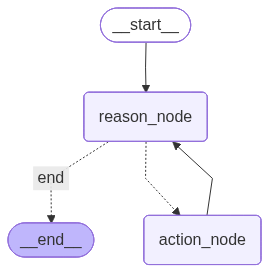

In [13]:
graph = StateGraph(GraphState)

graph.add_node('reason_node', reason_node)
graph.add_node('action_node', action_node)


def conditional_router(state: GraphState):
    if state['chat_history'][-1].tool_calls:
        return 'action_node'
    else:
        return 'end'

graph.add_edge(START, 'reason_node')
graph.add_conditional_edges('reason_node', conditional_router, {'action_node': 'action_node', 'end': END})
graph.add_edge('action_node', 'reason_node')


agent = graph.compile()

agent

In [14]:
user_id = '100' 
user_message = "I want to take leave tomorrow"

##  Decoding the Output

The Agent talks in "Code Objects," not plain English. This part of the loop acts like a **Translator**.
It looks at every message coming from the agent and figures out what it means:
1.  **"I need a tool!"** (`tool_calls`): The agent is asking to use the calculator or leave system.
2.  **"Here is the data!"** (`ToolMessage`): The tool finished and gave back a result (like "10 days").
3.  **"Here is my answer."** (`AIMessage`): The agent used the data to write a final response for you.

### Code Context
The `if/elif` blocks act as the sorter:
* `if msg.tool_calls`: Checks if the envelope contains a request to run a function (e.g., `get_time_off_balance`).
* `elif isinstance(msg, ToolMessage)`: Checks if the envelope contains data returned from a tool (e.g., `10`).
* `elif msg.content`: Checks if the envelope contains the final text for the user.

In [18]:
print("=" * 80)
print("🚀 Starting Agent Execution")
print("=" * 80)

for chunk in agent.stream({ 'user_id': user_id, 'chat_history' : [HumanMessage(content = user_message)] }, stream_mode="updates"):
    
    # Extract node name and data from chunk
    for node_name, node_data in chunk.items():
        print(f"\n{'─' * 80}")
        print(f"📍 Node: {node_name}")

        print(f"{'─' * 80}")
        
        # Check if there are messages in the chat_history
        if 'chat_history' in node_data:
            messages = node_data['chat_history']
            
            for msg in messages:
                # Handle AIMessage with tool calls
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"\n🤖 AI is calling tools:")
                    for tool_call in msg.tool_calls:
                        print(f"   • Tool: {tool_call['name']}")
                        print(f"   • Args: {tool_call['args']}")
                
                # Handle ToolMessage (results from tools)
                elif isinstance(msg, ToolMessage):
                    print(f"\n🔧 Tool Result:")
                    print(f"   {msg.content}")
                
                # Handle AIMessage with content (final response)
                elif hasattr(msg, 'content') and msg.content:
                    print(f"\n💬 AI Response:")
                    print(f"   {msg.content}")

print(f"\n{'=' * 80}")
print("✅ Agent Execution Complete")
print("=" * 80)

🚀 Starting Agent Execution

────────────────────────────────────────────────────────────────────────────────
📍 Node: reason_node
────────────────────────────────────────────────────────────────────────────────

🤖 AI is calling tools:
   • Tool: get_time_off_balance
   • Args: {'user_id': '100'}

────────────────────────────────────────────────────────────────────────────────
📍 Node: action_node
────────────────────────────────────────────────────────────────────────────────

🔧 Tool Result:
   10

────────────────────────────────────────────────────────────────────────────────
📍 Node: reason_node
────────────────────────────────────────────────────────────────────────────────

🤖 AI is calling tools:
   • Tool: process_time_off
   • Args: {'user_id': '100', 'start_date': '2026-01-08', 'end_date': '2026-01-08'}

────────────────────────────────────────────────────────────────────────────────
📍 Node: action_node
──────────────────────────────────────────────────────────────────────────────

## 5) Human-in-the-Loop (Interrupts)

Sometimes, the AI hits a roadblock. It might need a clarification, a password, or a missing date. Instead of guessing or failing, we want the AI to **hit the "Pause" button** and ask a human (You) for help.

Think of it like a video game:
1.  **Pause:** The game stops.
2.  **Player Input:** You change your equipment or check the map.
3.  **Resume:** You un-pause, and the game continues exactly from where it left off.

###  Code Context
In the code below:
* `interrupt(message)`: This function effectively pulls the emergency brake. The graph stops running at this exact line and waits.
* To make this work, we need a way to **Save** the game state so we can resume it later (covered in the next steps).

📚 **[Docs: HITL](https://docs.langchain.com/oss/python/langgraph/interrupts)**



In [13]:
from langgraph.types import interrupt

## 5.1) The "Ask for Help" Tool

We need to give the agent a specific way to trigger the pause. We do this by creating a special tool called `get_additional_info_from_human`.
When the AI realizes it's missing information (like an "End Date"), it calls this tool. This tool calls the `interrupt` function, which freezes the entire program and sends the question to the user.

### Code Context
In the code below:
* `interrupt(message)`: Halts execution and returns the `message` to the outer loop.
* The return value of this tool isn't calculated by Python—it will be provided by **You** when you manually resume the graph later.

In [14]:
# tools: 

@tool
def get_time_off_balance(user_id: str) -> int:
    '''
    Get the time off balance for a user. 

    Args :
        user_id: A unique string representing the user id

    Returns:
        An integer value representing the time-off balance
    '''
    return 10

@tool
def process_time_off(user_id: str, start_date: str, end_date: str) -> dict:
    '''
    Process time-off request for a user

    Args :
        user_id: A unique string representing the user id
        start_date: A date string in YYYY-MM-DD format for the start date of the time-off request
        end_date: A date string in YYYY-MM-DD format for the end date of the time-off request

    Returns:
        A dictionary with the following keys:
        - status: A string value representing the status of the time-off request
        - message: A string value representing the message of the time-off request
    '''
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    days_requested = end_date - start_date
    time_off_balance = get_time_off_balance.invoke({"user_id": user_id})

    result = {}

    if days_requested.days + 1 > time_off_balance:
        result['status'] = 'error'
        result['message'] = f'Time off request failed. you only have {time_off_balance} days of remaining leaves but requested {days_requested.days} days'

    else:
        time_off_balance -= days_requested.days + 1
        result['status'] = 'success'
        result['message'] = f'Time off request processed successfully for {days_requested.days + 1} days. Your remaining time off balance is {time_off_balance}'


    return result


@tool
def get_additional_info_from_human( message: str) -> str:
    '''
        Raises an interrupt to fetch additional information from the human requesting the action

        Args:
            message: a message string from the AI requesting the user for missing information

        Returns:
            A string value representing the response with additional information from the human

    '''
    interrupt_result = interrupt(message)

    return interrupt_result['user_message']




# Graph execution gets suspended at the exact point where interrupt is called
# State is saved using the checkpointer so execution can be resumed later, In production, this should be a persistent checkpointer (e.g. backed by a database)
# Value is returned to the caller under __interrupt__; it can be any JSON-serializable value (string, object, array, etc.)
# Graph waits indefinitely until you resume execution with a response
# Response is passed back into the node when you resume, becoming the return value of the interrupt() call




In [15]:
# Key points about resuming:
# You must use the same thread ID when resuming that was used when the interrupt occurred
# The value passed to Command(resume=...) becomes the return value of the interrupt call
# The node restarts from the beginning of the node where the interrupt was called when resumed, so any code before the interrupt runs again
# You can pass any JSON-serializable value as the resume value

## 5.2) Updating the Agent Nodes

Since we created a new tool, we need to update our workers ("Nodes") to use it.
We are re-creating the **Reason Node** and **Action Node**. The only difference is that the LLM now has access to the `get_additional_info_from_human` tool and knows it can use it when stuck.

###  Code Context
In the code below:
* `tools = [..., get_additional_info_from_human]`: We add the new interrupt tool to the list.
* `llm.bind_tools(tools)`: We give the updated toolkit to the LLM.

In [16]:
# nodes 

llm = init_chat_model(model="gpt-4o", temperature=0)
tools = [get_time_off_balance, process_time_off, get_additional_info_from_human ]
tools_by_name = {tool.name : tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

def reason_node(state: GraphState) -> GraphState:

    user_id = state['user_id']

    prompt_template = ChatPromptTemplate(
            [
                ('system', ACTION_PROMPT_TEMPLATE)
            ]
            +
            state['chat_history']
            
        )

    chain = prompt_template | llm_with_tools

    todays_date = datetime.now().strftime("%Y-%m-%d")

    llm_response = chain.invoke({'todays_date': todays_date, 'user_id': user_id})

    return {
            'chat_history': [llm_response]
        }

def action_node(state: GraphState):
        
    result = []

    for tool_call in state['chat_history'][-1].tool_calls:
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append(ToolMessage(content= str(observation), tool_call_id=tool_call["id"]))

    return {
        'chat_history': result
    }

## 6) Graph Compilation with Memory (Checkpointer)

If you pause a video game, you need a **Save File** so the console remembers where you were when you come back.
In LangGraph, this is called a **Checkpointer**. It saves the entire history of the conversation (the State) to memory (or a database) every time a step completes. This allows us to "Resume" the agent later.

###  Code Context
In the code below:
* `InMemorySaver()`: A temporary "Save File" that lives in RAM.
* `graph.compile(checkpointer=checkpointer)`: We tell the graph, *"Whenever you run, keep saving your progress to this checkpointer."*

📚 **[Docs: Persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/)**

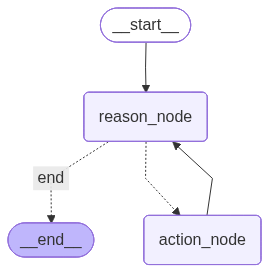

In [17]:
# Compile graph
from langgraph.checkpoint.memory import InMemorySaver

graph = StateGraph(GraphState)

graph.add_node('reason_node', reason_node)
graph.add_node('action_node', action_node)


def conditional_router(state: GraphState):
    if state['chat_history'][-1].tool_calls:
        return 'action_node'
    else:
        return 'end'

graph.add_edge(START, 'reason_node')
graph.add_conditional_edges('reason_node', conditional_router, {'action_node': 'action_node', 'end': END})
graph.add_edge('action_node', 'reason_node')

checkpointer = InMemorySaver()
agent = graph.compile(checkpointer=checkpointer)

agent

## 7) Running with Interrupts (The Game Loop)

This is the engine that drives our interactive agent.
1.  **Run:** The agent starts working.
2.  **Detect Interrupt:** We check if the agent stopped because of an `__interrupt__` event.
3.  **Human Input:** If it did, we ask you (the user) for the missing info.
4.  **Resume:** We use a special `Command` to "Inject" your answer back into the graph and un-pause it.

### Important Concept: The "Time Loop" (Re-execution)
* When you resume, the Agent doesn't just "unfreeze" mid-sentence. It actually **re-starts the current step (Node) from the beginning**.

###  Code Context
In the code below:
* `config={'configurable': {'thread_id': user_id}}`: Tells the Checkpointer *which* specific conversation thread we are pausing/resuming.
* `Command(resume={'user_message': ...})`: This is the "Un-pause" button. It takes your input and sends it back to the tool that called `interrupt`.

📚 **[Docs: Command & Resume](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#resume)**

In [18]:
# Human in the loop  in action

from langgraph.types import Command

user_id = '1' 
user_message = "I want to take leave"

config = {'configurable': {'thread_id': user_id}}

## 7.1) Decoding the Output (The Translator)
As with the earlier output segment, this loop iterates through the streamed `messages` and inspects each message object.
When it encounters an `Interrupt`, graph execution pauses and waits for a human response before resuming.

### Code Context
The `if/elif` blocks act as the sorting logic:
* `if msg.tool_calls`: Detects when the AI wants to **act** (call a function).
* `elif isinstance(msg, ToolMessage)`: Detects the **result** of that action (the return value).
* `elif msg.content`: Detects the **final spoken response** to the user.
* `if not interrupt_detected`: If the agent finished its job without hitting a "Pause" button (Interrupt), we print "Execution Complete" and exit the loop.

In [19]:

agent_input = {'user_id': user_id, 'chat_history' : [HumanMessage(content = user_message)]} # initial state

while True:
    interrupt_detected = False
    
    for chunk in agent.stream(agent_input, config=config , stream_mode="updates"):

        for node_name, node_data in chunk.items():
            print(f"\n{'─' * 80}")
            print(f"📍 Node: {node_name}")

            print(f"{'─' * 80}")

            if node_name == '__interrupt__':
                print(f"\n🔄 Interrupt for Human Input")
                print(f"   {node_data[0].value}")  

                interrupt_detected = True
                user_message = input("Human Input: ")
                agent_input = Command(resume={'user_message': user_message})
                
                break 
            
            
            # Check if there are messages in the chat_history
            if 'chat_history' in node_data:
                messages = node_data['chat_history']
                
                for msg in messages:
                    # Handle AIMessage with tool calls
                    if hasattr(msg, 'tool_calls') and msg.tool_calls:
                        print(f"\n🤖 AI is calling tools:")
                        for tool_call in msg.tool_calls:
                            print(f"   • Tool: {tool_call['name']}")
                            print(f"   • Args: {tool_call['args']}")
                    
                    # Handle ToolMessage (results from tools)
                    elif isinstance(msg, ToolMessage):
                        print(f"\n🔧 Tool Result:")
                        print(f"   {msg.content}")
                    
                    # Handle AIMessage with content (final response)
                    elif hasattr(msg, 'content') and msg.content:
                        print(f"\n💬 AI Response:")
                        print(f"   {msg.content}")
        
    
    if not interrupt_detected:
        print(f"\n{'=' * 80}")
        print("✅ Agent Execution Complete")
        print("=" * 80)
        
        break

        


────────────────────────────────────────────────────────────────────────────────
📍 Node: reason_node
────────────────────────────────────────────────────────────────────────────────

🤖 AI is calling tools:
   • Tool: get_additional_info_from_human
   • Args: {'message': 'Please provide the start and end dates for your leave request.'}

────────────────────────────────────────────────────────────────────────────────
📍 Node: __interrupt__
────────────────────────────────────────────────────────────────────────────────

🔄 Interrupt for Human Input
   Please provide the start and end dates for your leave request.

────────────────────────────────────────────────────────────────────────────────
📍 Node: action_node
────────────────────────────────────────────────────────────────────────────────

🔧 Tool Result:
   

────────────────────────────────────────────────────────────────────────────────
📍 Node: reason_node
─────────────────────────────────────────────────────────────────────────────

## 8) Managing Persistence

Since we are saving the "Game State," we can also inspect it or delete it.
* **Get State:** Look at what the AI currently remembers.
* **Delete Thread:** Clear the save file to start fresh.

### Code Context
In the code below:
* `checkpointer.get(...)`: Retreives the latest state for the given `thread_id`.
* `checkpointer.delete_thread(...)`: Wipes the memory for that specific user ID.

In [16]:
checkpointer.get({'configurable': {'thread_id': user_id}})

NameError: name 'checkpointer' is not defined

In [20]:
# Clear checkpoints for a specific thread
checkpointer.delete_thread(thread_id = '100')

# 🎓 Conclusion & Resources

You have successfully moved from simple Chains to complex **Agents with Memory and Human interaction**.

**We learned how to:**
* ✅ **Define State:** Shared memory for the graph.
* ✅ **Create Cycles:** Allowing the AI to Reason $\leftrightarrow$ Act multiple times.
* ✅ **Implement Interrupts:** Pausing for human input.
* ✅ **Use Persistence:** Saving and resuming thread states.

### 📚 Recommended Resources
* **[LangGraph Official Docs](https://langchain-ai.github.io/langgraph/)**: The bible for graph-based agents.
* **[LangGraph Persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/)**: Learn how to use Postgres/Redis for production memory.
* **[LangSmith Tracing](https://smith.langchain.com/)**: Visualize your graph's execution flow.